In [1]:
!pip3 -qq install torch==0.4.1
!pip install -qq bokeh==0.13.0
!pip install -qq eli5==0.8
!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5"

     |████████████████████████████████| 519.5MB 32kB/s 
ERROR: torchvision 0.6.1+cu101 has requirement torch==1.5.1, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
     |████████████████████████████████| 16.0MB 208kB/s 
     |████████████████████████████████| 102kB 6.9MB/s 


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    
np.random.seed(42)

# Свёрточные нейронные сети

## Классификация фамилий

Будем учиться предсказывать, является ли слово фамилией.

In [3]:
from sklearn.model_selection import train_test_split

with open('surnames.txt') as f:
    lines = f.readlines()
    data = [line.strip().split('\t')[0] for line in lines]
    labels = np.array([int(line.strip().split('\t')[1]) for line in lines])
    del lines
    
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=42)

Посмотрим на данные:

In [ ]:
list(zip(train_data, train_labels))[::1500]

[('вожакам', 0),
 ('посвящения', 0),
 ('изменницы', 0),
 ('тензорам', 0),
 ('Родзевич', 1),
 ('поломку', 0),
 ('ПРОВЕРКАМ', 0),
 ('майка', 0),
 ('ошеломлении', 0),
 ('эркере', 0),
 ('дешифрировании', 0),
 ('затоваривание', 0),
 ('громыханий', 0),
 ('выволочка', 0),
 ('Волдыри', 0),
 ('сербки', 0),
 ('ОТЛИЧИИ', 0),
 ('РАДИОГРАММА', 0),
 ('поэтике', 0),
 ('гобоя', 0),
 ('ОБЛАСТЯМИ', 0),
 ('пациентах', 0),
 ('трясогузка', 0),
 ('утепления', 0),
 ('Фингалу', 0),
 ('Хищение', 0),
 ('Джамал', 0),
 ('Лавчонка', 0),
 ('скольжению', 0),
 ('восстание', 0),
 ('Гудмэн', 1),
 ('консортах', 0),
 ('инфузорий', 0),
 ('постоянстве', 0),
 ('вахтенными', 0),
 ('полновластия', 0)]

Данные ещё и сильно несбалансированы - положительных примеров в несколько раз меньше:

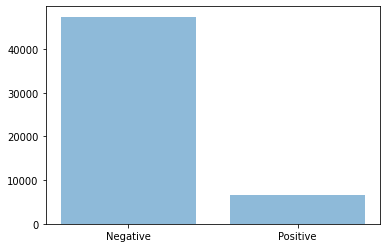

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

positive_count = np.sum(train_labels == 1)
negative_count = len(train_labels) - positive_count
 
plt.bar(np.arange(2), [negative_count, positive_count], align='center', alpha=0.5)
plt.xticks(np.arange(2), ('Negative', 'Positive'))
    
plt.show()

Accuracy очень легко оптимизировать - просто предсказывайте всегда ноль:

In [ ]:
print('Accuracy = {:.2%}'.format((train_labels == 0).mean()))

Accuracy = 87.90%


Однако это будет довольно бесполезно - всегда говорить, что слово не является фамилией. Это, конечно, вопрос - что хуже, зря объявить слово фамилией (ошибка первого рода) или не найти фамилию.

![](https://effectsizefaq.files.wordpress.com/2010/05/type-i-and-type-ii-errors.jpg)  
*From [effectsizefaq.com](https://effectsizefaq.com/2010/05/31/i-always-get-confused-about-type-i-and-ii-errors-can-you-show-me-something-to-help-me-remember-the-difference/)*

Будем замерять precision, recall и их комбинацию - $F_1$-меру.

![precision-recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)  
*From [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)*

$$\text{precision} = \frac{tp}{tp + fp}.$$
$$\text{recall} = \frac{tp}{tp + fn}.$$
$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.$$

Начнём с бейзлайна на регулярках.

In [4]:
#@title Супер-бейзлайн
surname_indicators = "^[А-Я][а-я], .*ский" #@param {type:"raw"}

surname_indicators = surname_indicators.split(', ')

import re

regexs = [re.compile(regex) for regex in surname_indicators]

preds = np.array([any(regex.match(word) for regex in regexs) for word in test_data])

from sklearn.metrics import f1_score
print('F1-score = {:.2%}'.format(f1_score(test_labels, preds)))

F1-score = 40.43%


А теперь серьёзно - бейзлайн на логистической регрессии поверх N-грамм символов.

**Задание** Сделать классификацию с LogisticRegression моделью. Посчитать F1-меру.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 3), lowercase=False)

X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

model = LogisticRegression(C=10).fit(X_train, train_labels)

test_preds = model.predict(X_test)
print('F1-score = {:.2%}'.format(f1_score(test_labels, test_preds)))

F1-score = 67.28%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Посмотрим на предсказания

In [ ]:
import eli5

eli5.show_weights(model, vec=vectorizer, top=40)

In [ ]:
sample_ind = np.random.randint(len(test_data))
eli5.show_prediction(model, test_data[sample_ind], vec=vectorizer, targets=['surname'], target_names=['word', 'surname'])

Кроме тупого подсчета F1-score можно посмотреть на precision-recall кривые. Во-первых, они красивые. Во-вторых, по ним видно, что можно повысить качество (F1-score), подобрав другой порог - **хотя на тесте это делать нельзя**.

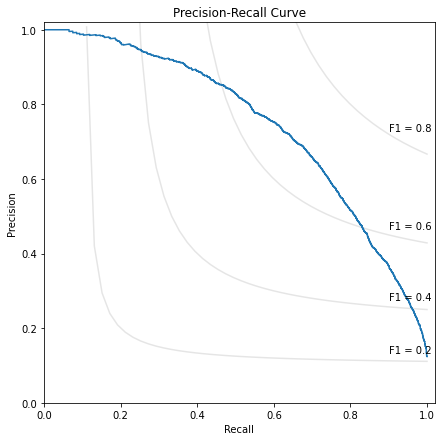

In [11]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_labels, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision)

plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

**Задание** Придумайте признаки, чтобы улучшить качество модели.

## Character-Level Convolutions

### Общее описание сверток

Напомню, свертки - это то, с чего начался хайп нейронных сетей в районе 2012-ого.

Работают они примерно так:  
![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   
From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

Но нужно не забывать, что свертки обычно имеют ещё такую размерность, как число каналов. Например, картинки имеют обычно три канала: RGB.  
Наглядно демонстрируется как выглядят при этом фильтры [здесь](http://cs231n.github.io/convolutional-networks/#conv).

После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность тензора, с которым приходится работать. Самым частым является max-pooling:  
![maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)  
From [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/#pool)

### Свёртки для текстов

Для текстов свертки работают как n-граммные детекторы (примерно). Каноничный пример символьной сверточной сети:

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)  
From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

*Сколько учится фильтров на данном примере?*

На картинке показано, как из слова извлекаются 2, 3 и 4-граммы. Например, желтые - это триграммы. Желтый фильтр прикладывают ко всем триграммам в слове, а потом с помощью global max-pooling извлекают наиболее сильный сигнал.

Что это значит, если конкретнее?

Каждый символ отображается с помощью эмбеддингов в некоторый вектор. А их последовательности - в конкатенации эмбеддингов.  
Например, "abs" $\to [v_a; v_b; v_s] \in \mathbb{R}^{3 d}$, где $d$ - размерность эмбеддинга. Желтый фильтр $f_k$ имеет такую же размерность $3d$.  
Его прикладывание - это скалярное произведение $\left([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R$ (один из желтых квадратиков в feature map для данного фильтра).

Max-pooling выбирает $max_i \left( [v_{i-1}; v_{i}; v_{i+1}] \odot f_k \right)$, где $i$ пробегается по всем индексам слова от 1 до $|w| - 1$ (либо по большему диапазону, если есть padding'и).   
Этот максимум соответствует той триграмме, которая наиболее близка к фильтру по косинусному расстоянию.

В результате в векторе после max-pooling'а закодирована информация о том, какие из n-грамм встретились в слове: если встретилась близкая к нашему $f_k$ триграмма, то в $k$-той позиции вектора будет стоять большое значение, иначе - маленькое.

А учим мы как раз фильтры. То есть сеть должна научиться определять, какие из n-грамм значимы, а какие - нет.

### Игрушечный пример

Посмотрим на примере, что там происходит. Возьмем слово:

In [12]:
word = 'Смирнов'

Для начала нужно перенумеровать символы:

In [13]:
char2index = {symb: ind for ind, symb in enumerate(set(word))}

char2index

{'С': 3, 'в': 4, 'и': 1, 'м': 2, 'н': 6, 'о': 5, 'р': 0}

Каждому символу сопоставляется эмбеддинг. Простейший способ сделать эмбеддинги - взять единичную матрицу. Когда у нас были десятки тысяч слов, такие эмбеддинги были не оч, а сейчас всего несколько символов вполне адекватно присвоить им ортогональные вектора небольшой размерности.

In [14]:
embeddings = torch.eye(len(char2index))

embeddings

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])

Построим тензор индексов символов слова:

In [15]:
word_tensor = torch.LongTensor([char2index[symb] for symb in word])

word_tensor

tensor([3, 2, 1, 0, 6, 5, 4])

Отобразим его в эмбеддинги. Получили такой же прямоугольничек, как на картинке (транспонирование нужно, чтобы смотрело в ту же сторону).

In [16]:
word_embs = embeddings[word_tensor].t()

word_embs

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])

Теперь дело дошло до сверток. Сделаем фильтр-детектор триграммы `нов`:

In [17]:
kernel_name = 'нов'

kernel_indices = torch.LongTensor([char2index[symb] for symb in kernel_name])
kernel_weights = embeddings[kernel_indices].t()

kernel_weights

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]])

Чтобы посчитать свёртку, воспользуемся функцией:

```python
F.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
```

input: input tensor of shape ($N \times C_{in} \times H_{in} \times W_{in}$)  
weight: filters of shape ($C_{out} \times C_{in} \times H_{out} \times W_{out}$)

$N$ - размер батча (1 у нас). $C_{in}$ - число каналов. В нашем случае оно всегда будет 1 (пока что). $C_{out}$ - число фильтров. Оно пока 1.

Нам понадобятся четырехмерные тензоры, для этого воспользуемся `view`:

In [18]:
word_embs = word_embs.view(1, 1, word_embs.shape[0], word_embs.shape[1])
kernel_weights = kernel_weights.view(1, 1, kernel_weights.shape[0], kernel_weights.shape[1])

conv_result = F.conv2d(word_embs, kernel_weights)[0, 0]

print('Conv =', conv_result)
print('Max pooling =', conv_result.max())

Conv = tensor([[0., 0., 0., 0., 3.]])
Max pooling = tensor(3.)


Свертка сказала, что данный фильтр есть на последней позиции. Пулинг сказал, пофиг на какой позиции - главное, он есть.

### Подготовка данных

Первый шаг - определить, какой длины слова у нас. Ограничимся каким-то числом, а более длинные будем обрезать.

In [19]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for word in train_data:
    word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word length for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word length for 99% of words is 17


Соберем отображение из символов в индексы.

In [20]:
chars = set()
for word in train_data:
    chars.update(word)

char_index = {c : i + 1 for i, c in enumerate(chars)}
char_index['<pad>'] = 0
    
print(char_index)

{'2': 1, '«': 2, 'И': 3, '-': 4, 'Щ': 5, 'Ё': 6, '7': 7, 'Ó': 8, 'Р': 9, 'м': 10, 'Ч': 11, 'Х': 12, 'х': 13, 'П': 14, 'с': 15, 'ш': 16, 'э': 17, 'ы': 18, 'Ш': 19, 'н': 20, 'У': 21, 'а': 22, 'п': 23, 'Л': 24, ' ': 25, 'ъ': 26, 'б': 27, 'Я': 28, '·': 29, '»': 30, 'Ъ': 31, 'и': 32, 'Й': 33, 'Т': 34, 'В': 35, 'С': 36, 'ч': 37, 'в': 38, 'Ы': 39, 'й': 40, 'л': 41, 'ф': 42, 'Ю': 43, 'ж': 44, 'г': 45, 'ц': 46, 'р': 47, 'ь': 48, '.': 49, '3': 50, 'д': 51, 'Г': 52, 'з': 53, 'Д': 54, 'Н': 55, 'е': 56, 'Ь': 57, '”': 58, 'Ф': 59, 'З': 60, 'К': 61, 'о': 62, '/': 63, '4': 64, 'я': 65, '’': 66, 'М': 67, '“': 68, 'А': 69, 'к': 70, 'Е': 71, 'ó': 72, 'ё': 73, 'т': 74, 'ю': 75, 'Б': 76, 'Э': 77, 'щ': 78, 'ѐ': 79, "'": 80, 'Ж': 81, 'у': 82, 'О': 83, 'Ц': 84, '<pad>': 0}


**Задание** Сконвертируйте данные

In [21]:
def convert_data(data, max_word_len, char_index):
    result = np.zeros((len(data), max_word_len))
    for i, word in enumerate(data):
        word = word[-max_word_len:]
        result[i][:len(word)] = [char_index.get(symb, 0) for symb in word]
  
    return result

X_train = convert_data(train_data, MAX_WORD_LEN, char_index)
X_test = convert_data(test_data, MAX_WORD_LEN, char_index)

In [22]:
def iterate_batches(X, y, batch_size):
    num_samples = X.shape[0]

    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        
        batch_idx = indices[start: end]
        
        yield X[batch_idx], y[batch_idx]

### MyFirstConvCharNN

Теперь построим свёрточную модель.

Пусть она будет строить триграммы - то есть применять фильтры на 3 символа.

Начнем с последовательности: `nn.Embedding -> nn.Conv2d -> nn.ReLU -> max pooling -> nn.Linear`

`nn.Conv2d` - это слой, содержащий создание и инициализацию фильтров, и вызов `F.conv2d` к ним и входу.

*Лайфхак:* последовательности операций можно запаковывать в `nn.Sequential`.

In [55]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.2)
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(5, emb_dim)),
            nn.ReLU()
            )
        self._out_layer = nn.Linear(filters_count, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        outputs = self._embedding(inputs)
        outputs = outputs.unsqueeze(1)
        outputs = self._conv3(outputs).max(dim=2)[0]
        outputs = outputs.squeeze(-1)
        return outputs


Проверьте, что всё работает:

In [56]:
X_batch, y_batch = next(iterate_batches(X_train, train_labels, 32))
X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

model = ConvClassifier(len(char_index) + 1, 24, 64)
logits = model(X_batch)
logits.shape

torch.Size([32])

**Задание** Подсчитайте precision, recall и F1-score для полученных предсказаний.

In [58]:
def TP(logits, labels):
    logits_bin = logits.ge(0).type(torch.long).cpu()
    return torch.dot(logits_bin, labels.cpu()).data.tolist()

def FP(logits, labels):
    logits_bin = logits.ge(0).type(torch.long).cpu()
    return torch.dot(logits_bin, labels.eq(0).type(torch.long).cpu()).data.tolist()

def FN(logits, labels):
    logits_bin = logits.ge(0).type(torch.long).cpu()
    return torch.dot(logits_bin.eq(0).type(torch.long).cpu(), labels.cpu()).data.tolist()


def _precision(tp, fp):
    return tp / (tp + fp) if tp + fp != 0 else 0

def _recall(tp, fn):
    return tp / (tp + fn) if tp + fn != 0 else 0


def f1_scr(precision, recall):
    return 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0

f1_scr(_precision(TP(logits, y_batch), FP(logits, y_batch) ), _recall( TP(logits, y_batch), FN(logits, y_batch)))

0.3157894736842105

**Задание** Напишем теперь цикл обучения, который не слишком сложно будет переиспользовать

In [59]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss, epoch_tp, epoch_fp, epoch_fn = 0, 0, 0, 0
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(data.shape[0] / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size)):
            X_batch, y_batch = LongTensor(X_batch), FloatTensor(y_batch)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            y_batch = y_batch.type(torch.long)
            tp = TP(logits, y_batch)
            fp = FP(logits, y_batch)
            fn = FN(logits, y_batch)

            precision = _precision(tp, fp)
            recall = _recall(tp, fn)
            f1 = f1_scr(precision, recall)
            
            epoch_tp += tp
            epoch_fp += fp
            epoch_fn += fn

            print('\r[{} / {}]: Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'.format(
                  i, batchs_count, loss.item(), precision, recall, f1), end='')
        
    precision = _precision(epoch_tp, epoch_fp)
    recall = _recall(epoch_tp, epoch_fn)
    f1 = f1_scr(precision, recall)
        
    return epoch_loss / batchs_count, recall, precision, f1

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_recall, train_precision, train_f1 = do_epoch(
            model, criterion, train_data, batch_size, optimizer
        )
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
        if not val_data is None:
            val_loss, val_recall, val_precision, val_f1 = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss, train_recall, train_precision, train_f1,
                                     val_loss, val_recall, val_precision, val_f1))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [61]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=100, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 100, Epoch Time = 4.38s: Train Loss = 0.3228, Precision = 2.34%, Recall = 67.70%, F1 = 4.53%, Val Loss = 0.2892, Precision = 9.42%, Recall = 73.57%, F1 = 16.70%
Epoch 2 / 100, Epoch Time = 4.34s: Train Loss = 0.2624, Precision = 19.74%, Recall = 76.53%, F1 = 31.38%, Val Loss = 0.2506, Precision = 26.16%, Recall = 79.44%, F1 = 39.36%
Epoch 3 / 100, Epoch Time = 4.35s: Train Loss = 0.2315, Precision = 33.45%, Recall = 78.44%, F1 = 46.90%, Val Loss = 0.2298, Precision = 39.27%, Recall = 77.87%, F1 = 52.21%
Epoch 4 / 100, Epoch Time = 4.37s: Train Loss = 0.2113, Precision = 42.57%, Recall = 78.92%, F1 = 55.31%, Val Loss = 0.2165, Precision = 44.60%, Recall = 77.94%, F1 = 56.74%
Epoch 5 / 100, Epoch Time = 4.44s: Train Loss = 0.1987, Precision = 48.41%, Recall = 78.96%, F1 = 60.02%, Val Loss = 0.2101, Precision = 42.29%, Recall = 81.64%, F1 = 55.71%
Epoch 6 / 100, Epoch Time = 4.46s: Train Loss = 0.1879, Precision = 52.24%, Recall = 80.36%, F1 = 63.32%, Val Loss = 0.2012, Precisio

**Задание** Проверьте работу классификатора на вашей фамилии.

Нужно не забыть перевести модель в режим инференса - некоторые слои на трейне и инференсе ведут себя по-разному.

In [65]:
model.eval()

surname = 'Дмитриев'
surname_tensor = LongTensor(convert_data([surname], MAX_WORD_LEN, char_index))
print('P({} is surname) = {}'.format(surname, torch.sigmoid(model(surname_tensor))))

P(Дмитриев is surname) = tensor([0.0015], device='cuda:0', grad_fn=<SigmoidBackward>)


**Задание** Постройте precision-recall curve для данного классификатора и предыдущей модели

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

inputs = LongTensor(X_test)
logits = model(inputs).data.cpu().numpy()
precision, recall, _ = precision_recall_curve(test_labels, logits)

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

## Визуализации

### Визуализация эмбеддингов

**Задание** Визуализируем эмбеддинги слов, как это делали раньше

In [67]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

# from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = umap.UMAP(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

In [70]:
word_indices = np.random.choice(np.arange(len(test_data)), 1000, replace=False)
words = [test_data[ind] for ind in word_indices]
labels = test_labels[word_indices]

word_tensor = LongTensor(convert_data(words, max(len(x) for x in words), char_index))
embeddings = model.embed(word_tensor).detach().cpu().numpy()

colors = ['red' if label else 'blue' for label in labels]

visualize_embeddings(embeddings, words, colors)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=100)
Construct fuzzy simplicial set
Mon Jul 13 20:02:43 2020 Finding Nearest Neighbors
Mon Jul 13 20:02:45 2020 Finished Nearest Neighbor Search
Mon Jul 13 20:02:47 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


### Визуализация полученных свёрток

Кроме всего прочего у нас тут логистическая регрессия сверху. Можно визуализировать ее также, как в eli5.

**Задание** Добиться этого.

In [ ]:
model.eval()

word = 'Смирнов'

Посчитайте вероятность, что слово - фамилия.

In [ ]:
inputs = word -> LongTensor
prob = torch.sigmoid(model(inputs)).item()

Посчитайте результат свертки и пулинга

In [ ]:
convs = ...
maxs, positions = convs.squeeze().max(-1)

Домножьте выход пулинга на веса выходного слоя

In [ ]:
linear_weights = ...

Посчитайте веса символов: каждый фильтр прикладывается к какой-то позиции - прибавим его вес к накрываемым символам.

In [ ]:
symb_weights = ...

Визуализируем это:

In [ ]:
from IPython.core.display import HTML

def get_color_hex(weight):
    cmap = plt.get_cmap("RdYlGn")
    rgba = cmap(weight, bytes=True)
    return '#%02X%02X%02X' % rgba[:3]

symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
res = '<p>P(surname) = {:.2%}</p>'.format(prob)
for symb, weight in zip(word, symb_weights):
    res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
res = '<p>' + res + '</p>'

HTML(res)

Объединим все в функции:

In [ ]:
def calc_weights(word):
    <calc>
    
    return prob, symb_weights

def visualize(word):
    prob, symb_weights = calc_weights(word)
    
    symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
    res = '<p>P(surname) = {:.2%}</p>'.format(prob)
    for symb, weight in zip(word, symb_weights):
        res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
    res = '<p>' + res + '</p>'
    return HTML(res)


visualize('Королев')

## Улучшение модели

**Задание** Для улучшение стабильности модели стоит добавить дропаут `nn.Dropout` - способ занулять часть весов на каждой эпохе для регуляризации модели. Попробуйте добавить его после эмбеддингов и после свертки (а можно еще где-нибудь).

![](https://cdn-images-1.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png)


**Задание** Другой способ регуляризовывать модель - использовать BatchNormalization (`nn.BatchNorm2d`). Попробуйте добавить его после свертки.

**Задание** Еще способ улучшить модель - добавить сверток. Реализуйте модель как на картинке в начале ноутбука: со свертками на 2, 3, 4 символа.

**Задание** Различают Narrow и Wide свёртки - по сути, добавляется ли нулевой паддинг или нет. Для текстов эта разница выглядит так:  
![narrow_vs_wide](https://image.ibb.co/eqGZaS/2018_03_28_11_23_17.png)
*From Neural Network Methods in Natural Language Processing.*

Слева - паддинг отсутствует, справа - есть. Попробуйте добавить паддинг и посмотреть, что получится. Потенциально он поможет выучить хорошие префиксы слова.

# Дополнительные материалы

## Почитать

### Основы
[Convolutional Neural Networks, cs231n](http://cs231n.github.io/convolutional-networks/)  
[Understanding Convolutions, Christopher Olah](http://colah.github.io/posts/2014-07-Understanding-Convolutions/)  
[Understanding Convolutional Neural Networks for NLP, Denny Britz](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

### Статьи
[Character-Aware Neural Language Models, Yoon Kim et al, 2015](https://arxiv.org/abs/1508.06615)  
[Character-level Convolutional Networks for Text Classification, Zhang et al., 2015](https://arxiv.org/abs/1509.01626)  
[A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification Zhang et al., 2015](https://arxiv.org/abs/1510.03820)
[Learning Character-level Representations for Part-of-Speech Tagging, dos Santos et al, 2014](http://proceedings.mlr.press/v32/santos14.pdf)

## Посмотреть
[cs224n "Lecture 13: Convolutional Neural Networks"](https://www.youtube.com/watch?v=Lg6MZw_OOLI)

# Сдача задания

[Форма](https://goo.gl/forms/FfMnyNGI2P4xo0QD3)